In [1]:
import tarfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy
import os, sys, time, re,pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from viz import GetQHulls
import seaborn as sns
sns.set_style("white")

In [2]:
dataset_name = ['visual_1020', '20180410-BY3_1kgenes']
# dataset_name = ['visual_1020', '20180505_BY3_1kgenes']
folder = os.path.join('..', 'original_files', *dataset_name)

In [3]:
expr = np.load(os.path.join(folder, 'cell_barcode_count.npy'))
print(f'cell*gene = {expr.shape}')

cell*gene = (973, 1020)


In [4]:
df = pd.read_csv(os.path.join(folder, 'class_labels.csv'))
clusterID = df['ClusterID'].values
clusterName = df['ClusterName'].values
del df

In [5]:
expr_cell = expr.sum(1)
if dataset_name[0] == 'visual_160':
    assert np.all(((expr_cell > 200) & (expr_cell <= 3000)) == (clusterID != -1))
elif dataset_name[0] == 'visual_1020':
    print(((expr_cell > 200) & (expr_cell <= 3000)).sum())
    print((clusterID != -1).shape)
    assert np.all(((expr_cell > 200) & (expr_cell <= 3000)) == (clusterID != -1))
else:
    assert False
valid_cell = clusterID != -1
print(f'# cells passed filters = {valid_cell.sum()}')

930
(973,)
# cells passed filters = 930


In [6]:
expr_norm = np.log1p(1e4 * expr / expr.sum(1, keepdims=True))

In [7]:
(expr_norm != 0).mean()

0.28049996977208147

In [8]:
gene_name = []
with open(os.path.join(folder, 'genes.csv'), 'r') as f:
    for line in f:
        gene_name.append(line.strip().split(',')[0])

In [9]:
img = np.load(os.path.join(folder, 'labels.npz'))['labels']
qhulls, coords = GetQHulls(img)
centroids = np.vstack([c.mean(0) for c in coords])

blah
0 / 975
1 / 975
2 / 975
3 / 975
4 / 975
5 / 975
6 / 975
7 / 975
8 / 975
9 / 975
10 / 975
11 / 975
12 / 975
13 / 975
14 / 975
15 / 975
16 / 975
17 / 975
18 / 975
19 / 975
20 / 975
21 / 975
22 / 975
23 / 975
24 / 975
25 / 975
26 / 975
27 / 975
28 / 975
29 / 975
30 / 975
31 / 975
32 / 975
33 / 975
34 / 975
35 / 975
36 / 975
37 / 975
38 / 975
39 / 975
40 / 975
41 / 975
42 / 975
43 / 975
44 / 975
45 / 975
46 / 975
47 / 975
48 / 975
49 / 975
50 / 975
51 / 975
52 / 975
53 / 975
54 / 975
55 / 975
56 / 975
57 / 975
58 / 975
59 / 975
60 / 975
61 / 975
62 / 975
63 / 975
64 / 975
65 / 975
66 / 975
67 / 975
68 / 975
69 / 975
70 / 975
71 / 975
72 / 975
73 / 975
74 / 975
75 / 975
76 / 975
77 / 975
78 / 975
79 / 975
80 / 975
81 / 975
82 / 975
83 / 975
84 / 975
85 / 975
86 / 975
87 / 975
88 / 975
89 / 975
90 / 975
91 / 975
92 / 975
93 / 975
94 / 975
95 / 975
96 / 975
97 / 975
98 / 975
99 / 975
100 / 975
101 / 975
102 / 975
103 / 975
104 / 975
105 / 975
106 / 975
107 / 975
108 / 975
109 / 975
110 /

In [10]:
expr_norm = expr_norm[valid_cell]
centroids = centroids[valid_cell]

In [12]:
# neighbor_method_str = 'KNN graph'
neighbor_method_str = 'Delaunay'
if neighbor_method_str == 'KNN graph':
    radius = 40
    n_neighbors = 5
    neighbor_str = f'r{radius}_n{n_neighbors}'
elif neighbor_method_str == 'Delaunay':
#     radius = 300
    radius = 600
    neighbor_str = f'Delaunay_r{radius}'
else:
    assert False

if neighbor_method_str == 'KNN graph':
    nbrs = sklearn.neighbors.NearestNeighbors(
        n_neighbors=n_neighbors,
        radius=radius,
        metric='euclidean',
    ).fit(X)
#     dists, E = nbrs.radius_neighbors(X)
    dist, E = nbrs.kneighbors()
    E = [[v for d, v in zip(disti, Ei) if d <= radius] for disti, Ei in zip(dist, E)]
    E = [set(list(e)) for e in E]
    for u, Eu in enumerate(E):
        for v in Eu:
            E[v] |= {u}
elif neighbor_method_str == 'Delaunay':
    E = [set() for _ in centroids]
    tri = scipy.spatial.Delaunay(centroids)
    for simplex in tri.simplices:
        simplex = set(list(simplex))
        for u in simplex:
            E[u] |= simplex
    for u in range(len(centroids)):
        E[u] -= {u}
        E[u] = set([v for v in E[u] if np.linalg.norm(centroids[u] - centroids[v]) <= radius])
else:
    assert False
assert all(i in E[j] for i, e in enumerate(E) for j in e)
l = np.array(list(map(len, E)))
print(
    f'min = {l.min()}, mean = {l.mean():.1f}, median = {np.median(l)}, max = {l.max()}; '
    f'# = {len(centroids)}, #0 = {(l==0).sum()}')

min = 2, mean = 5.6, median = 6.0, max = 10; # = 930, #0 = 0


In [9]:
t = '_'.join(dataset_name)
pd.DataFrame(data=expr[valid_cell].astype(int), columns=gene_name)\
    .to_csv(f'../results/expr.csv', index=False)

In [11]:
t = '_'.join(dataset_name)
print(t)
np.savetxt(f'../files/expression_{t}_raw.tsv', expr[valid_cell])
with open(f'../files/expression_{t}.pkl', 'wb') as f: pickle.dump(expr_norm, f)
with open(f'../files/coordinates_{t}.pkl', 'wb') as f: pickle.dump(centroids, f)
with open(f'../files/genes_{t}.txt', 'w') as f: f.write('\n'.join(gene_name) + '\n')
with open(f'../files/neighborhood_{t}_{neighbor_str}.txt', 'w') as f:
    for u, e in enumerate(E):
        for v in e:
            if u >= v: continue
            f.write(f'{u}\t{v}\n')
with open(f'../files/cell_types_{t}.txt', 'w') as f: f.write('\n'.join(clusterName[valid_cell]) + '\n')

visual_1020_20180410-BY3_1kgenes


<AxesSubplot:xlabel='Y', ylabel='X'>

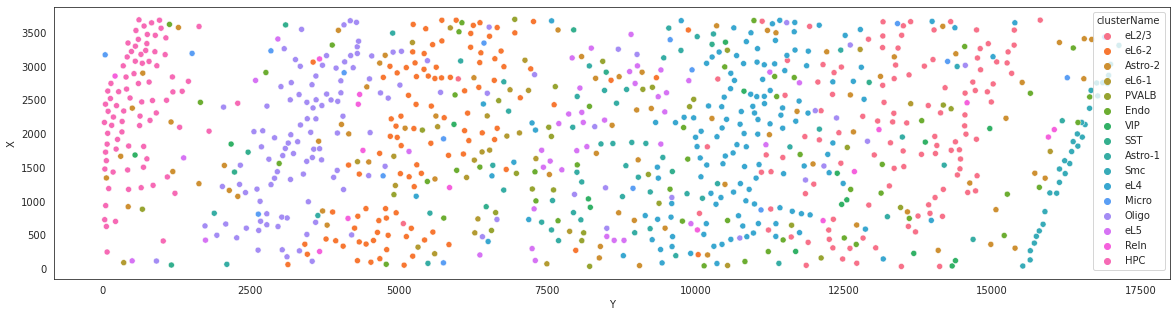

In [14]:
df = pd.DataFrame(centroids)
df.columns = ['X', 'Y']
df['clusterID'] = clusterID[valid_cell]
df['clusterName'] = clusterName[valid_cell]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
sns.scatterplot(data=df, x='Y', y='X', hue='clusterName', ax=ax)